# Fashion Retail Data Analysis

### Introduction:
This project analyzes sales data from a fashion retail business to provide insights into customer purchasing behavior, product performance, and store performance. Our goal is to identify key customers, top-performing products, and store revenue trends to inform business strategy.

### Tools Used:
- Pandas, SQLite3, Matplotlib, Seaborn

In [12]:
### Data Import + Data Cleansing
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# importing csv data
customer_data = pd.read_csv('/Users/nickcohn24/Desktop/Career - in full/Resume-Projects/Fashion Retail/fashion datafiles/customer_data.csv')
product_data = pd.read_csv('/Users/nickcohn24/Desktop/Career - in full/Resume-Projects/Fashion Retail/fashion datafiles/product_data.csv')
sales_data = pd.read_csv('/Users/nickcohn24/Desktop/Career - in full/Resume-Projects/Fashion Retail/fashion datafiles/sales_data.csv')
store_data = pd.read_csv('/Users/nickcohn24/Desktop/Career - in full/Resume-Projects/Fashion Retail/fashion datafiles/store_data.csv')

# inspecting columns
'''
print(customer_data.columns)
print(product_data.columns)
print(sales_data.columns)
print(store_data.columns)
'''

# cleaning the data by handling critical missing values
customer_data = customer_data.dropna(subset=['customer_id'])
product_data = product_data.dropna(subset=['product_id'])
sales_data = sales_data.dropna(subset=['transaction_id', 'product_id', 'store_id', 'customer_id', 'date', 'quantity'])
store_data = store_data.dropna(subset=['store_id'])


We dropped rows with missing critical identifiers (the id's) to ensurereliable SQL joins and aggregation. Most other fields holding minor missing values were left intact.

In [13]:
### SQL Table Creation

# creating our sql database and tables
connection = sqlite3.connect('fashion_retail.db')
cur = connection.cursor()

customer_data.to_sql('customers', connection, if_exists='replace', index=False)
product_data.to_sql('products', connection, if_exists='replace', index=False)
store_data.to_sql('stores', connection, if_exists='replace', index=False)
sales_data.to_sql('transactions', connection, if_exists='replace', index=False) 

48156

Tables for customers, products, stores, and transactions (using sales.csv) are created with SQLite, allowing for efficient querying and aggregation across our csv datasets.

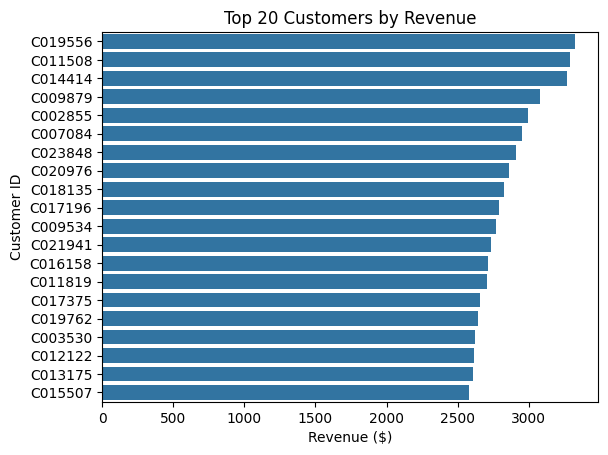

,customer_id,city,total_purchases_discounted
0,C019556,Lisbon,3321.532
1,C011508,Coimbra,3290.434
2,C014414,Coimbra,3267.740
3,C009879,Braga,3079.862
4,C002855,Lisbon,2997.714
5,C007084,Coimbra,2950.976
6,C023848,Braga,2907.786
7,C020976,Lisbon,2860.913
8,C018135,Lisbon,2827.348
9,C017196,Coimbra,2790.560


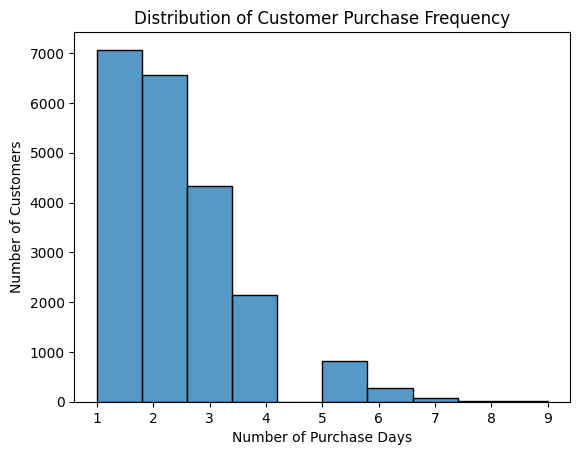

,customer_id,purchase_dates
0,C023848,9
1,C012184,9
2,C011508,9
3,C006278,9
4,C003530,9
...,...,...
21270,C000037,1
21271,C000026,1
21272,C000019,1
21273,C000011,1


In [14]:
### Customer Insights Section

# top 20 customers by total purchases
query = '''
SELECT c.customer_id, c.city, SUM(t.quantity * p.list_price * (1 - IFNULL(discount, 0))) AS total_purchases_discounted
FROM transactions t
JOIN customers c ON t.customer_id = c.customer_id
JOIN products p ON t.product_id = p.product_id
GROUP BY c.customer_id, c.city
ORDER BY total_purchases_discounted DESC
LIMIT 20
;'''
top_customers = pd.read_sql(query, connection)
plt.figure()
sns.barplot(x='total_purchases_discounted', y='customer_id', data=top_customers)
plt.xlabel('Revenue ($)')
plt.ylabel('Customer ID')
plt.title('Top 20 Customers by Revenue')
plt.savefig('figures/top_products_revenue.png', dpi=250)
plt.show()
display(top_customers)

# customer purhcase frequency
query = '''
SELECT customer_id, COUNT(DISTINCT date) AS purchase_dates
FROM transactions
GROUP BY customer_id
ORDER BY purchase_dates DESC'''
purchase_frequency = pd.read_sql(query, connection)
plt.figure()
sns.histplot(data=purchase_frequency, x='purchase_dates', bins=10, kde=False)
plt.xlabel('Number of Purchase Days')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Purchase Frequency')
plt.savefig('figures/purchase_frequency.png', dpi=250)
plt.show()
display(purchase_frequency)


### Customer Insights Observations

Top Customers by Revenue:
- The top 20 customers generate significantly higher revenue than the average customer, with total discounted purchases ranging roughly between $2580 and $3320.
- Coimbra, Braga, and Lisbon dominate the top 20, with 7 customers, 5 customers, and 4 customers respectively. This suggests that these cities are key markets for high-value customers.
- Since a small percentage of customers contribute disproportionately to the revenue, we should focus on these high-value customers.

Customer Purchase Frequency:
- Most customers purchase on fewer than 5 distinct dates, indicating that repeat purchases are relatively rare.
- A small group of customers, such as those with 9 purchase dates, are frequent buyers, representing the loyal customers.

Overall insights:
- Consider city-focused marketing in Coimbra, Braga, and Lisbon in order to target high-value customers.
- Investigate common characteristics among top spenders and frequent buyers to expand the high-value customer base.
- Implement customer-loyalty programs to encourage more frequent purchases; this will increase retention and will turn occasional buyers into "loyal customers"


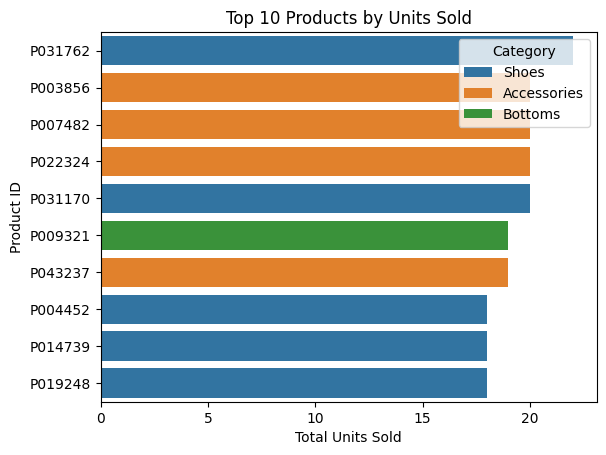

,product_id,category,total_units_sold
0,P031762,Shoes,22
1,P003856,Accessories,20
2,P007482,Accessories,20
3,P022324,Accessories,20
4,P031170,Shoes,20
5,P009321,Bottoms,19
6,P043237,Accessories,19
7,P004452,Shoes,18
8,P014739,Shoes,18
9,P019248,Shoes,18


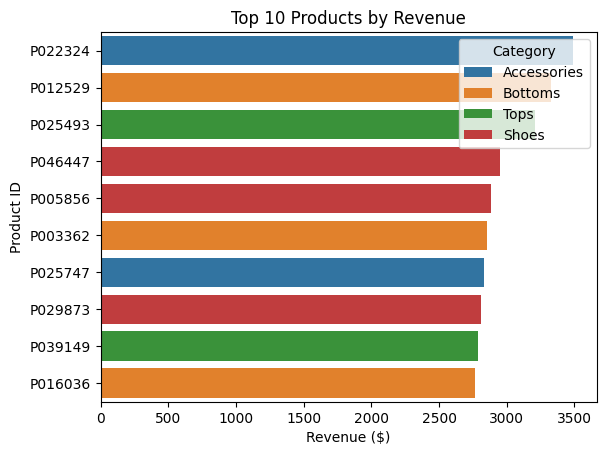

,product_id,category,revenue
0,P022324,Accessories,3488.800
1,P012529,Bottoms,3330.300
2,P025493,Tops,3209.444
3,P046447,Shoes,2952.393
4,P005856,Shoes,2881.602
5,P003362,Bottoms,2855.364
6,P025747,Accessories,2832.624
7,P029873,Shoes,2806.958
8,P039149,Tops,2788.024
9,P016036,Bottoms,2764.656


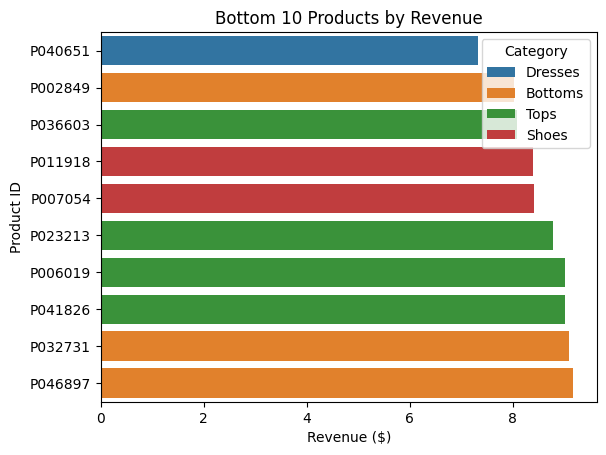

,product_id,category,revenue
0,P040651,Dresses,7.329
1,P002849,Bottoms,8.024
2,P036603,Tops,8.092
3,P011918,Shoes,8.400
4,P007054,Shoes,8.408
5,P023213,Tops,8.778
6,P006019,Tops,9.009
7,P041826,Tops,9.018
8,P032731,Bottoms,9.096
9,P046897,Bottoms,9.176


In [15]:
## Product Performance Section

# top 10 products by units sold
query = '''
SELECT p.product_id, p.category, SUM(t.quantity) AS total_units_sold
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id, p.category
ORDER BY total_units_sold DESC
LIMIT 10
;'''
top_products_units = pd.read_sql(query, connection)
plt.figure()
sns.barplot(x='total_units_sold', y='product_id', hue='category', data=top_products_units)
plt.xlabel('Total Units Sold')
plt.ylabel('Product ID')
plt.title('Top 10 Products by Units Sold')
plt.legend(title='Category')
plt.savefig('figures/top_products_units.png', dpi=250)
plt.show()
display(top_products_units)

# top 10 products by revenue
query = '''
SELECT p.product_id, p.category, SUM(t.quantity * p.list_price * (1 - IFNULL(discount, 0))) AS revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id, p.category
ORDER BY revenue DESC
LIMIT 10
;'''
top_products_revenue = pd.read_sql(query, connection)
plt.figure()
sns.barplot(x='revenue', y='product_id', hue='category', data=top_products_revenue)
plt.xlabel('Revenue ($)')
plt.ylabel('Product ID')
plt.title('Top 10 Products by Revenue')
plt.legend(title='Category')
plt.savefig('figures/top_products_revenue.png', dpi=250)
plt.show()
display(top_products_revenue)

# bottom 10 products by revenue
query = '''
SELECT p.product_id, p.category, SUM(t.quantity * p.list_price * (1 - IFNULL(discount, 0))) AS revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id, p.category
ORDER BY revenue ASC
LIMIT 10
;'''
bottom_products_revenue = pd.read_sql(query, connection)
plt.figure()
sns.barplot(x='revenue', y='product_id', hue='category', data=bottom_products_revenue)
plt.xlabel('Revenue ($)')
plt.ylabel('Product ID')
plt.title('Bottom 10 Products by Revenue')
plt.legend(title='Category')
plt.savefig('figures/bottom_products_revenue.png', dpi=250)
plt.show()
display(bottom_products_revenue)


### Product Performance Observations

Top 10 Products by Units Sold:
- Shoes and accessories dominate the list of top-selling products by units, appearing 5 times and 4 times respectively
- The highest-selling product is P031762 (shoes) at 22 units sold.
- Certain categories consistently drive unit sales, likely reflecting popular product types of price points that encourage multiple purchases. Seeing as shoes and accessories are commonly replaced clothing, it makes sense for these to be most frequently purchased.

Top and Bottom 10 Products by Revenue:
- The highest-revenue product is P022324 (accessories) with $3488.80, even though accessories did not always have the highest units sold.
- High revenue doesn't align with the highest units sold for this dataset
- Consider focusing on higher-margin products for revenue growth
- Bottom products have extremly low revenue, indicating very low sales or low-priced items, including dresses, bottoms, tops, and shoes
- These bottom products might be poor performers, so consider discontinuation of them, placing new discounts on them, or promoting them differently.

Overall 
- Products with high unit sales but lower list price may generate less revenue than moderately selling, higher-priced products

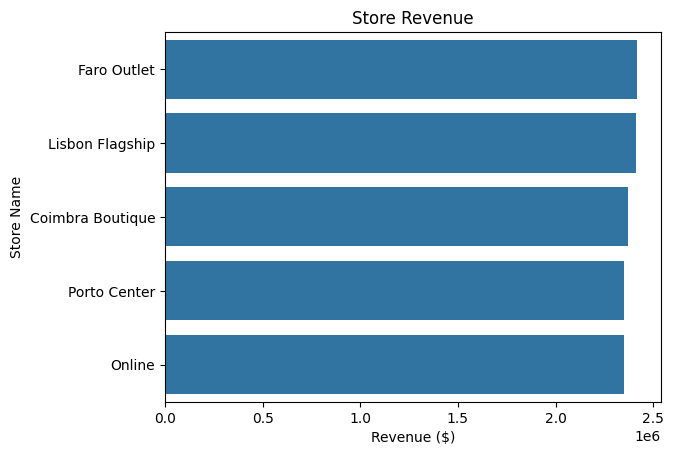

,store_id,store_name,total_revenue
0,S003,Faro Outlet,2418159.025
1,S001,Lisbon Flagship,2413181.997
2,S005,Coimbra Boutique,2369401.989
3,S002,Porto Center,2351611.755
4,S004,Online,2349876.776


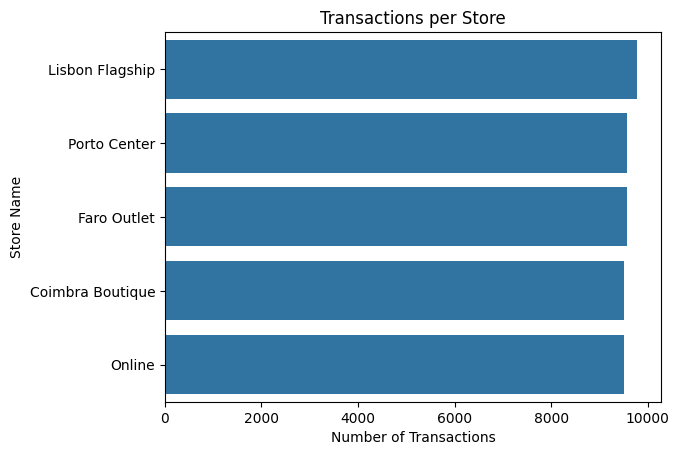

,store_id,store_name,num_transactions
0,S001,Lisbon Flagship,9785
1,S002,Porto Center,9581
2,S003,Faro Outlet,9566
3,S005,Coimbra Boutique,9517
4,S004,Online,9513


In [16]:
## Store Performance Section

# total revenue per store
query = '''
SELECT s.store_id, s.store_name, SUM(t.quantity * p.list_price * (1 - IFNULL(discount, 0))) AS total_revenue
FROM transactions t
JOIN stores s ON t.store_id = s.store_id
JOIN products p ON t.product_id = p.product_id
GROUP BY s.store_id, s.store_name
ORDER BY total_revenue DESC
;'''
store_revenue = pd.read_sql(query, connection)
plt.figure()
sns.barplot(x='total_revenue', y='store_name', data=store_revenue)
plt.xlabel('Revenue ($)')
plt.ylabel('Store Name')
plt.title('Store Revenue')
plt.savefig('figures/store_revenue.png', dpi=250)
plt.show()
display(store_revenue)

# number of transactions per store
query = '''
SELECT s.store_id, s.store_name, COUNT(t.transaction_id) AS num_transactions
FROM transactions t
JOIN stores s ON t.store_id = s.store_id
GROUP BY s.store_id, s.store_name
ORDER BY num_transactions DESC
;'''
store_transactions = pd.read_sql(query, connection)
plt.figure()
sns.barplot(x='num_transactions', y='store_name', data=store_transactions)
plt.xlabel('Number of Transactions')
plt.ylabel('Store Name')
plt.title('Transactions per Store')
plt.savefig('figures/store_transactions.png', dpi=250)
plt.show()
display(store_transactions)


### Store Performance Observations

Total Revenue per Store:
- x

Number of Transactions per Store:
- x
